In [1]:
import numpy as np
import pandas as pd
import random as rnd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

In [2]:
train_df = pd.read_csv('../input/train.csv', index_col=0)
test_df = pd.read_csv('../input/test.csv', index_col=0)

In [3]:
# 检查数据
train_df.head(20)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B33C46DB70>,
      dtype=object)

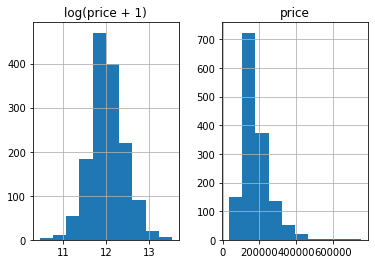

In [4]:
# 把label“平滑化”（正态化），使学习更加准确
# 最后计算结果的时候一定要转换回去（log1p()--expm1();log()--exp()）
prices = pd.DataFrame({"price":train_df["SalePrice"], "log(price + 1)":np.log1p(train_df["SalePrice"])})
prices.hist()

In [5]:
# 把标签先pop出来，方便训练数据和测试数据进行合并
y_train = np.log1p(train_df.pop('SalePrice'))

In [6]:
# 合并train_d和ftest_df，方便对数据进行处理
all_df = pd.concat((train_df, test_df), axis=0)

## 特征工程

#### 1. one-hot

In [7]:
# 有一些隐藏在numerical数值中的category数值，将其转换为Str格式
all_df['MSSubClass'] = all_df['MSSubClass'].astype(str)
all_df['YrSold'] = all_df['YrSold'].astype(str)
# 统计查看
print(all_df['MSSubClass'].value_counts(), all_df['YrSold'].value_counts())

20     1079
60      575
50      287
120     182
30      139
70      128
160     128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64 2007    692
2009    647
2008    622
2006    619
2010    339
Name: YrSold, dtype: int64


In [8]:
# 把所有的category数值独热化处理
all_dummy_df = pd.get_dummies(all_df)
all_dummy_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
2,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
3,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
4,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
5,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0


#### 2. numerical数值处理

① 缺失值处理

In [9]:
# 首先进行缺失值处理，先看一下那些数据有缺失
all_dummy_df.isnull().sum().sort_values(ascending=False).head(10)

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
BsmtFinSF2        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
GarageArea        1
dtype: int64

In [10]:
# 在这里用平均值填满空缺
mean_cols = all_dummy_df.mean()
all_dummy_df = all_dummy_df.fillna(mean_cols)
# 看看还有没有空缺
all_dummy_df.isnull().sum().sum()

0

② 标准化

In [11]:
# 首先找到数值变量
numeric_cols = all_df.columns[all_df.dtypes != 'object']
# 对每一列数值变量进行 (X-X')/s 标准化
numeric_col_means = all_dummy_df.loc[:, numeric_cols].mean()
numeric_col_std = all_dummy_df.loc[:, numeric_cols].std()
all_dummy_df.loc[:, numeric_cols] = (all_dummy_df.loc[:, numeric_cols] - numeric_col_means) / numeric_col_std

In [12]:
all_dummy_df.head(10)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,-2.020329e-01,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.525112,0.580807,-0.293080,-0.934702,...,0,0,0,1,0,0,0,0,1,0
2,5.017845e-01,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.572152,1.177910,-0.293080,-0.629788,...,0,0,0,1,0,0,0,0,1,0
3,-6.126943e-02,0.137173,0.646073,-0.507197,0.980053,0.848819,0.334770,0.097856,-0.293080,-0.288467,...,0,0,0,1,0,0,0,0,1,0
4,-4.366387e-01,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.572152,-0.494856,-0.293080,-0.047266,...,0,0,0,1,1,0,0,0,0,0
5,6.894691e-01,0.518814,1.355319,-0.507197,0.947040,0.753100,1.387248,0.468851,-0.293080,-0.161040,...,0,0,0,1,0,0,0,0,1,0
6,7.363903e-01,0.500430,-0.772420,-0.507197,0.715952,0.513801,-0.572152,0.637883,-0.293080,-1.130393,...,0,0,0,1,0,0,0,0,1,0
7,2.671787e-01,-0.010665,1.355319,-0.507197,1.079091,0.992399,0.469129,2.036246,-0.293080,-0.554698,...,0,0,0,1,0,0,0,0,1,0
8,-1.800332e-14,0.027119,0.646073,0.391170,0.055700,-0.539116,0.771437,0.916678,-0.103928,-0.784521,...,0,0,0,1,0,0,0,0,1,0
9,-8.589292e-01,-0.513264,0.646073,-0.507197,-1.330831,-1.639892,-0.572152,-0.969026,-0.293080,0.890230,...,0,0,0,1,1,0,0,0,0,0


## 模型建立

In [13]:
# 把数据集分回训练集/数据集
dummy_train_df = all_dummy_df.loc[train_df.index]
dummy_test_df = all_dummy_df.loc[test_df.index]

In [14]:
# 把DataFrame数据转换为NumpyArray数据
X_train = dummy_train_df.values
X_test = dummy_test_df.values

In [15]:
# Ridge方法进行交叉验证训练，并调参
alphas = np.logspace(-3, 2, 50)
test_scores = []
for alpha in alphas:
    clf = Ridge(alpha)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

Text(0.5, 1.0, 'Alpha vs CV Error')

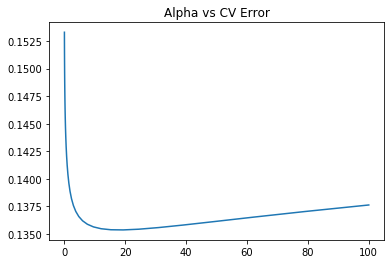

In [16]:
plt.plot(alphas, test_scores)
plt.title("Alpha vs CV Error")

## Ensemble

In [17]:
# 使用最好的parameter当做模型参数
ridge = Ridge(alpha=15)

In [29]:
# XGBoost方法
params = [1, 2, 3, 4, 5, 6]
test_scores = []
for param in params:
    clf = XGBRegressor(max_depth=param)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

Text(0.5, 1.0, 'max_depth vs CV Error')

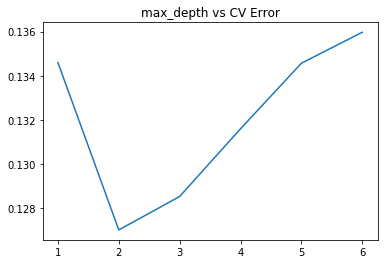

In [30]:
plt.plot(params, test_scores)
plt.title("max_depth vs CV Error")

In [31]:
test_scores

[0.13459831349256873,
 0.1270307821752058,
 0.1285420239737726,
 0.1316056409261323,
 0.1345689376613046,
 0.13597000067086762]

In [44]:
# 使用最好的参数2建立最终模型
clf = XGBRegressor(max_depth=5)

In [45]:
# 训练模型
clf.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [47]:
# 准确率查看
acc_clf = round(clf.score(X_train, y_train) * 100, 2)
acc_clf

99.71

In [37]:
ridge.fit(X_train, y_train)

Ridge(alpha=15, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [46]:
acc_clf2 = round(ridge.score(X_train, y_train) * 100, 2)
acc_clf2

92.11

In [48]:
# 预测测试数据，并把之前“平滑化”的标签转换回去
y_clf = np.expm1(clf.predict(X_test))
y_ridge = np.expm1(ridge.predict(X_test))

In [49]:
y_final = (y_ridge + y_clf) / 2

In [50]:
# 提交结果
submission_df = pd.DataFrame(data= {'Id' : test_df.index, 'SalePrice': y_final})
submission_df.head(10)

,Id,SalePrice
0,1461,120389.479392
1,1462,159058.269230
2,1463,179073.375938
3,1464,194713.751500
4,1465,191380.101298
5,1466,172272.278561
6,1467,178736.001746
7,1468,167399.015364
8,1469,183698.628956
9,1470,122279.046550


In [51]:
# 写入文件
submission_df.to_csv('submission3.csv', index=False)